In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125
import seaborn as sns
from Bio import SeqIO, Seq
import scipy.stats as st
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import glob, os, sys, yaml, subprocess, itertools, sparse
from functools import reduce

import warnings
warnings.filterwarnings(action='ignore')

who_variants_combined = pd.read_csv("../analysis/who_confidence_2021.csv")
drug_gene_mapping = pd.read_csv("../data/drug_gene_mapping.csv")
samples_summary = pd.read_csv("../data/samples_summary.csv")
snp_scheme = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
snp_scheme["#lineage"] = snp_scheme["#lineage"].str.replace("lineage", "")
snp_scheme.rename(columns={"#lineage": "Lineage"}, inplace=True)

lineages = pd.read_csv("../data/combined_lineages_samples.csv", low_memory=False)
solo_results = pd.read_csv("SOLO_Final_Aug2023.csv", header=[1])
assert len(solo_results["FINAL CONFIDENCE GRADING"].unique()) == 5

# utils files are in a separate folder
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *
from data_utils import *

# CHANGE ANALYSIS DIR BEFORE RUNNING THE NOTEBOOK!
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'
drugs_lst = os.listdir(analysis_dir)
assert len(drugs_lst) == 16

# SOLO vs. Regression Comparison

In [77]:
confidence_mapping = {'1) Assoc w R': "Assoc w R - strict",
                           "2) Assoc w R - Interim": "Possible Assoc w R",
                           "3) Uncertain significance": "Uncertain",
                           "4) Not assoc w R - Interim": "Possible Assoc w S",
                           '5) Not assoc w R': "Assoc w S - strict"
                          }

np.sort(solo_results["FINAL CONFIDENCE GRADING"].unique())

array(['1) Assoc w R', '2) Assoc w R - Interim',
       '3) Uncertain significance', '4) Not assoc w R - Interim',
       '5) Not assoc w R'], dtype=object)

In [78]:
def make_solo_regression_comparison_table(drug, solo_results):

    df = pd.read_csv(f"FINAL/{drug}.csv")#.query("Tier in @tiers_lst")

    # solo uses LoF, but I've been using lof, so replace
    df.loc[df["predicted_effect"]=='lof', "mutation"] = df.mutation.str.replace("lof", "LoF")
    # solo_results_single_drug = solo_results.query("drug==@drug & tier in @tiers_lst").rename(columns={"FINAL CONFIDENCE GRADING": "SOLO_CONFIDENCE_GRADING"})
    solo_results_single_drug = solo_results.query("drug==@drug").rename(columns={"FINAL CONFIDENCE GRADING": "SOLO_CONFIDENCE_GRADING"})

    # combine with solo results
    df = solo_results_single_drug[["variant", "SOLO_CONFIDENCE_GRADING"]].merge(df[["mutation", "regression_confidence"]].rename(columns={"mutation": "variant"}), 
                                                                                on="variant", how="inner"
                                                                               )

    # create a mapping between the categories of the SOLO algorithm and regression so that they can be compared
    confidence_mapping = {"Assoc w R": "1) Assoc w R",
                          "Assoc w R - Interim": "2) Assoc w R - Interim",
                          "Uncertain": "3) Uncertain significance",
                          "Assoc w S - Interim": "4) Not assoc w R - Interim",
                          "Assoc w S": "5) Not assoc w R",
                          "Neutral": "5) Not assoc w R"
                          }

    # all pairs (exhaustive list, so 5 x 5)
    pairs = list(itertools.product(np.unique(list(confidence_mapping.values())), np.unique(list(confidence_mapping.values()))))
    
    # add new column denoting the gradings of the regression model, if they were transformed to the list they use
    df["REGRESSION_CONFIDENCE_GRADING"] = df["regression_confidence"].map(confidence_mapping)
    del df["regression_confidence"]
    
    # get counts of mutations across the groups
    counts_df = pd.DataFrame(df[["SOLO_CONFIDENCE_GRADING", "REGRESSION_CONFIDENCE_GRADING"]].value_counts()).reset_index().rename(columns={0:"Count"})
    
    # for pairs that are 0, they won't appear in the above dataframe, so manually add them with Count = 0
    for (a, b) in pairs:
    
        if len(counts_df.query("SOLO_CONFIDENCE_GRADING==@a & REGRESSION_CONFIDENCE_GRADING==@b")) == 0:
            counts_df = pd.concat([counts_df, pd.DataFrame({"SOLO_CONFIDENCE_GRADING": a, 
                                                            "REGRESSION_CONFIDENCE_GRADING": b,
                                                            "count": 0
                                                           }, index=[0])])
    
    counts_df = counts_df.reset_index(drop=True)
    assert len(counts_df) == len(pairs)
    
    # return both the dataframe of mutation and the summary counts dataframe 
    return df, counts_df.pivot(index="REGRESSION_CONFIDENCE_GRADING", columns="SOLO_CONFIDENCE_GRADING", values="count").fillna(0).astype(int)

In [132]:
tier1_full_results = {}
tier1_comparison_tables = {}

# for drug in os.listdir(analysis_dir):
for drug in drugs_lst:
    
    results_df, counts_df = make_solo_regression_comparison_table(drug, solo_results)
    tier1_full_results[drug] = results_df
    tier1_comparison_tables[drug] = counts_df

    counts_df.columns = pd.MultiIndex.from_tuples(zip(['SOLO_CONFIDENCE_GRADING']*len(counts_df.columns), counts_df.columns))
    counts_df.to_csv(f"Comparison_Tables/{drug}_comparison_table.csv")
    
summed_tier1_variants_across_drugs = reduce(lambda x, y: x.add(y, fill_value=0), list(tier1_comparison_tables.values()))
summed_tier1_variants_across_drugs

SOLO_CONFIDENCE_GRADING,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
REGRESSION_CONFIDENCE_GRADING,,,,,
1) Assoc w R,251,93,137,0,0
2) Assoc w R - Interim,0,68,82,1,1
3) Uncertain significance,2,889,12818,4662,174
4) Not assoc w R - Interim,0,0,8,1,4
5) Not assoc w R,0,0,30,21,17


In [110]:
tier1_full_results["Capreomycin"].query("SOLO_CONFIDENCE_GRADING=='5) Not assoc w R' & REGRESSION_CONFIDENCE_GRADING == '2) Assoc w R - Interim'")

,variant,SOLO_CONFIDENCE_GRADING,REGRESSION_CONFIDENCE_GRADING
174,rrs_n.514A>C,5) Not assoc w R,2) Assoc w R - Interim


In [96]:
tier1_full_results["Capreomycin"]

,variant,SOLO_CONFIDENCE_GRADING,REGRESSION_CONFIDENCE_GRADING
0,rrs_n.1001C>G,3) Uncertain significance,3) Uncertain significance
1,rrs_n.-101_-100insG,3) Uncertain significance,3) Uncertain significance
2,rrs_n.1010_1011insC,3) Uncertain significance,3) Uncertain significance
3,rrs_n.1016G>A,3) Uncertain significance,3) Uncertain significance
4,rrs_n.1016G>C,3) Uncertain significance,3) Uncertain significance
...,...,...,...
461,tlyA_p.Val46Glu,3) Uncertain significance,3) Uncertain significance
462,tlyA_p.Val54fs,2) Assoc w R - Interim,3) Uncertain significance
463,tlyA_p.Val54Gly,3) Uncertain significance,3) Uncertain significance
464,tlyA_p.Val7Phe,3) Uncertain significance,3) Uncertain significance


In [88]:
search_lst = tier1_full_results["Pyrazinamide"].query("SOLO_CONFIDENCE_GRADING == '2) Assoc w R - Interim' & REGRESSION_CONFIDENCE_GRADING == '3) Uncertain significance'").variant.values

tier1_full_results["Pyrazinamide"].query("SOLO_CONFIDENCE_GRADING == '2) Assoc w R - Interim' & REGRESSION_CONFIDENCE_GRADING == '3) Uncertain significance'")

,variant,SOLO_CONFIDENCE_GRADING,REGRESSION_CONFIDENCE_GRADING
454,pncA_c.-11A>T,2) Assoc w R - Interim,3) Uncertain significance
502,pncA_c.-7T>C,2) Assoc w R - Interim,3) Uncertain significance
508,pncA_p.Ala102fs,2) Assoc w R - Interim,3) Uncertain significance
511,pncA_p.Ala102Thr,2) Assoc w R - Interim,3) Uncertain significance
516,pncA_p.Ala143fs,2) Assoc w R - Interim,3) Uncertain significance
...,...,...,...
1006,pncA_p.Val44Gly,2) Assoc w R - Interim,3) Uncertain significance
1008,pncA_p.Val45fs,2) Assoc w R - Interim,3) Uncertain significance
1013,pncA_p.Val7fs,2) Assoc w R - Interim,3) Uncertain significance
1017,pncA_p.Val7Phe,2) Assoc w R - Interim,3) Uncertain significance


In [93]:
df.query("mutation in @search_lst")[["mutation", "WHO_Num_Isolates", "WHO_PPV_LB", "ALL_Num_Isolates", "ALL_PPV_LB"]]#.query("WHO_Num_Isolats >= 3 | ALL_Num_Isolates >= 3")

,mutation,WHO_Num_Isolates,WHO_PPV_LB,ALL_Num_Isolates,ALL_PPV_LB
123,pncA_p.Gly108Glu,3.0,0.292402,4,0.397635
124,pncA_p.Asp12fs,4.0,0.397635,4,0.397635
127,pncA_p.Cys14*,4.0,0.397635,4,0.397635
131,pncA_p.Tyr103fs,4.0,0.397635,4,0.397635
132,pncA_c.-11A>T,4.0,0.397635,4,0.397635
...,...,...,...,...,...
997,pncA_p.Tyr95fs,NaN,NaN,2,0.158114
998,pncA_p.Ala79fs,NaN,NaN,2,0.158114
1002,pncA_p.Ser66*,NaN,NaN,1,0.025000
1003,pncA_p.Phe13fs,NaN,NaN,1,0.025000


In [81]:
df = pd.read_csv("FINAL/Pyrazinamide.csv")

In [76]:
df.query("WHO_regression_confidence == 'Uncertain' & ALL_regression_confidence == 'Assoc w S'")[["mutation", "WHO_regression_confidence", "ALL_regression_confidence", "regression_confidence"]]

,mutation,WHO_regression_confidence,ALL_regression_confidence,regression_confidence
241,mmpL5_p.Arg202fs,Uncertain,Assoc w S,Assoc w S - Interim
258,mmpL5_lof,Uncertain,Assoc w S,Assoc w S - Interim


In [66]:
BDQ_excel = pd.read_excel("BINARY/Bedaquiline.xlsx", sheet_name=None)

In [69]:
BDQ_excel['T1,WHO,noSyn_unpooled'].query("mutation in ['mmpL5_p.Arg202fs', 'mmpL5_lof']")

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,pval,BH_pval,neutral_pval,BH_neutral_pval,...,LR-_UB,pool_type,synonymous,regression_confidence,MIC_coef,BH_MIC_pval,Use_MIC_Evidence,single_lineage,Initial_Confidence_Grading,Phenos
208,mmpL5_p.Arg202fs,1,frameshift,777876;777875,3) Uncertain significance,0.950177,0.031,0.069942,0.75,1.0,...,1.002376,unpooled,0,Uncertain,-0.263279,0.0,0,4,3) Uncertain significance,WHO


In [75]:
BDQ_excel['T1,WHO,noSyn_poolSeparate'].query("mutation in ['mmpL5_p.Arg202fs', 'mmpL5_lof']")[["mutation", "Odds_Ratio", "BH_pval", "NPV_LB", "NPV", "NPV_UB", "Num_Isolates"]]

,mutation,Odds_Ratio,BH_pval,NPV_LB,NPV,NPV_UB,Num_Isolates
4,mmpL5_lof,0.80579,0.025552,0.597875,0.619522,0.640819,4


In [21]:
for drug in drugs_lst:

    search_df = tier1_full_results[drug].query("REGRESSION_CONFIDENCE_GRADING == '2) Assoc w R - Interim' & SOLO_CONFIDENCE_GRADING == '5) Not assoc w R'")
    if len(search_df) > 0:
        print(drug)

Capreomycin


In [32]:
tier1_comparison_tables["Pyrazinamide"]

SOLO_CONFIDENCE_GRADING,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
REGRESSION_CONFIDENCE_GRADING,,,,,
1) Assoc w R,139,13,0,0,0
2) Assoc w R - Interim,0,22,0,0,0
3) Uncertain significance,1,167,398,273,6
4) Not assoc w R - Interim,0,0,0,0,0
5) Not assoc w R,0,0,1,3,1


In [29]:
len(tier1_full_results["Bedaquiline"].variant.unique()), len(tier1_full_results["Bedaquiline"])

(814, 814)

In [31]:
tier1_full_results["Bedaquiline"].query("SOLO_CONFIDENCE_GRADING=='5) Not assoc w R' & REGRESSION_CONFIDENCE_GRADING == '3) Uncertain significance'")

,variant,SOLO_CONFIDENCE_GRADING,REGRESSION_CONFIDENCE_GRADING
179,mmpL5_p.Asp767Asn,5) Not assoc w R,3) Uncertain significance


In [34]:
compens_lst = ['c.-47_-46insT', 'c.-48G>A', 'c.-51G>A', 'c.-81C>T', 'c.-76T>A', 'c.-57C>T', 'c.-52C>T', 'c.-52C>A', 'c.-88_-87insAT', 'c.-77T>G', 'c.-72C>T', 'c.-54C>T', 'c.-74G>A', ]
compens_lst = ["ahpC_" + val for val in compens_lst]

# 'c.-42T>C' not in dataset, but 'c.-42T>G' is
neutral_lst = ['c.-88G>A', 'c.-46G>A', 'c.-84T>C', 'c.-42T>C', 'c.-42T>G', 'c.-88G>A', 'c.-10G>A', 'c.33G>A']
neutral_lst = ["ahpC_" + val for val in neutral_lst]

print(len(np.unique(compens_lst)), len(np.unique(neutral_lst)))

13 7


In [35]:
df = pd.read_csv("FINAL/Isoniazid.csv")

df.query("mutation in @neutral_lst").sort_values("WHO_Odds_Ratio", ascending=False)[["mutation", "WHO_regression_confidence", "ALL_regression_confidence", "regression_confidence"]]

,mutation,WHO_regression_confidence,ALL_regression_confidence,regression_confidence
706,ahpC_c.-42T>G,Uncertain,Uncertain,Uncertain
1423,ahpC_c.-84T>C,Uncertain,Uncertain,Uncertain
1443,ahpC_c.-10G>A,Uncertain,Uncertain,Uncertain
1620,ahpC_c.-88G>A,Neutral,Neutral,Neutral


In [36]:
df.query("mutation in @compens_lst").sort_values("WHO_Odds_Ratio", ascending=False)[["mutation", "WHO_regression_confidence", "ALL_regression_confidence", "regression_confidence"]]

,mutation,WHO_regression_confidence,ALL_regression_confidence,regression_confidence
13,ahpC_c.-48G>A,Assoc w R,Assoc w R,Assoc w R
14,ahpC_c.-57C>T,Assoc w R,Assoc w R,Assoc w R
16,ahpC_c.-52C>T,Assoc w R,Assoc w R,Assoc w R
17,ahpC_c.-76T>A,Assoc w R,Assoc w R,Assoc w R
21,ahpC_c.-54C>T,Assoc w R,Assoc w R,Assoc w R
36,ahpC_c.-81C>T,Possible Assoc w R,Possible Assoc w R,Uncertain
38,ahpC_c.-52C>A,Possible Assoc w R,Possible Assoc w R,Uncertain
65,ahpC_c.-47_-46insT,Possible Assoc w R,Possible Assoc w R,Uncertain
68,ahpC_c.-51G>A,Possible Assoc w R,Possible Assoc w R,Uncertain
136,ahpC_c.-72C>T,Possible Assoc w R,Assoc w R,Assoc w R - Interim


In [18]:
df.query("mutation in @neutral_lst").sort_values("WHO_Odds_Ratio", ascending=False)[["mutation", "WHO_regression_confidence", "ALL_regression_confidence", "regression_confidence"]]#[["mutation", 'predicted_effect', 'position', 'Odds_Ratio',
       # 'BH_pval', 'BH_neutral_pval', 'BH_LRT_pval', 'BH_LRT_neutral_pval',
       # 'Num_Isolates', 'PPV',
       # 'NPV','PPV_LB', 'NPV_LB', 'regression_confidence', 'MIC_coef',
       # 'BH_MIC_pval', 'Use_MIC_Evidence',
       # 'WHO_regression_confidence', 'ALL_regression_confidence']]

,mutation,WHO_regression_confidence,ALL_regression_confidence,regression_confidence
706,ahpC_c.-42T>G,Uncertain,Uncertain,Uncertain
1423,ahpC_c.-84T>C,Uncertain,Uncertain,Uncertain
1443,ahpC_c.-10G>A,Uncertain,Uncertain,Uncertain
1620,ahpC_c.-88G>A,Neutral,Neutral,Neutral


# Number of Mutations that Used MIC Evidence for Up/Downgrading

In [37]:
for drug in drugs_lst:
    df = pd.read_csv(f"FINAL/{drug}.csv")

    if len(df.query("Use_MIC_Evidence == 1")) > 0:
        print(drug, len(df.query("Use_MIC_Evidence == 1")))

Ethambutol 4
Rifampicin 1
Isoniazid 1
Ethionamide 2


# Compute Mutation List Binary Statistics

In [53]:
all_drugs_stats = []

for drug in drugs_lst:

    for pheno in ["WHO", "ALL"]:
        
        if os.path.isfile(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={pheno}/catalog_results.csv")):
            df = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={pheno}/catalog_results.csv"), index_col=0)
            df *= 100
            df = df[plot_cols].rename(columns={"Precision": "PPV"})
            df.index = ["lower", "test", "upper"]
            df["Drug"] = drug
            df["Phenos"] = pheno
    
            all_drugs_stats.append(df.reset_index().rename(columns={"index": "CI"}))

all_drugs_stats = pd.concat(all_drugs_stats)

In [50]:
len(all_drugs_stats.Drug.unique()), all_drugs_stats.Phenos.unique()

(16, array(['WHO', 'ALL'], dtype=object))

In [54]:
all_drugs_stats

,CI,AUC,Sens,Spec,PPV,Drug,Phenos
0,lower,89.746002,82.871247,96.381830,86.680171,Levofloxacin,WHO
1,test,90.521642,84.289368,96.753916,87.986270,Levofloxacin,WHO
2,upper,91.297282,85.633728,97.097580,89.206863,Levofloxacin,WHO
0,lower,90.549919,84.586186,96.368684,86.361156,Levofloxacin,ALL
1,test,91.065125,85.512428,96.617823,87.250304,Levofloxacin,ALL
...,...,...,...,...,...,...,...
1,test,76.335758,83.646358,69.025157,60.704787,Ethionamide,WHO
2,upper,77.648921,85.174808,70.490307,62.455667,Ethionamide,WHO
0,lower,81.084409,79.381388,82.571929,60.323359,Ethionamide,ALL
1,test,81.823719,80.480824,83.166614,61.486880,Ethionamide,ALL


In [61]:
all_drugs_stats.melt(id_vars=["Drug", "Phenos", "CI"]).sort_values(["Drug", "Phenos", "variable", "CI"]).to_csv("catalog_stats_with_95CI.csv", index=False)

,index,AUC,Sens,Spec,PPV,Drug,Phenos
0,lower,89.746002,82.871247,96.381830,86.680171,Levofloxacin,WHO
1,test,90.521642,84.289368,96.753916,87.986270,Levofloxacin,WHO
2,upper,91.297282,85.633728,97.097580,89.206863,Levofloxacin,WHO
3,lower,90.549919,84.586186,96.368684,86.361156,Levofloxacin,ALL
4,test,91.065125,85.512428,96.617823,87.250304,Levofloxacin,ALL
...,...,...,...,...,...,...,...
88,test,76.335758,83.646358,69.025157,60.704787,Ethionamide,WHO
89,upper,77.648921,85.174808,70.490307,62.455667,Ethionamide,WHO
90,lower,81.084409,79.381388,82.571929,60.323359,Ethionamide,ALL
91,test,81.823719,80.480824,83.166614,61.486880,Ethionamide,ALL


0.0
1.2
2.4
3.6


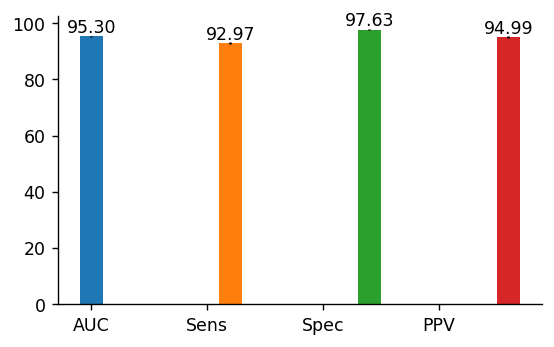

In [24]:
# Transpose the DataFrame for easier plotting
# plot_df = plot_df.T
plot_cols = ["AUC", "Sens", "Spec", "Precision"]
plot_df = df[plot_cols].rename(columns={"Precision": "PPV"})

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

fig, ax = plt.subplots(figsize=(5, 3))

# # Create the bar plot with error bars
# bars = ax.bar(range(len(plot_df.columns)), plot_df.loc['value'], yerr=[plot_df.loc['value'] - plot_df.loc['lower'], plot_df.loc['upper'] - plot_df.loc['value']], align='center', alpha=0.7, capsize=4, edgecolor='black', error_kw={"linewidth": 1})

# # Add bar labels
# for bar in bars:
#     height = bar.get_height()
#     ax.annotate(f'{height:.1f}', (bar.get_x() + bar.get_width() / 2., height / 2),
#                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')

bar_width = 0.2
ci_widths = plot_df.loc['upper'] - plot_df.loc['lower']

# Set the positions for the grouped bars
positions = np.arange(len(plot_df.columns))

# Plot the bars for each group
for i, col in enumerate(plot_df.columns):
    x = positions[i] + i * bar_width# - (len(df.columns) - 1) * bar_width / 2
    print(x)
    bars = ax.bar(x, plot_df.loc['value', col], width=bar_width,
                  yerr=ci_widths[col] / 2, label=col)

    # Add bar labels
    for bar in bars:
        height = bar.get_height() 
        ax.annotate(f'{height:.2f}', (bar.get_x() + bar.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Set the x-axis ticks and labels
ax.set_xticks(ticks=range(len(plot_df.columns)), labels=plot_df.columns)

# change_width(ax, .65)
sns.despine()
plt.show()

In [10]:
x

3.3

In [69]:
for cont in ax.containers:
    # labels = np.round(cont, 1)
    #ax.bar_label(cont, fmt='{:.2f}', label_type="edge", fontsize="12")
    print(cont[0])

Rectangle(xy=(-0.4, 0), width=0.8, height=56.2895, angle=0)


In [ ]:
for cont in ax.containers:
    # labels = np.round(cont, 1)
    ax.bar_label(cont, fmt='{:.2f}', label_type="edge", fontsize="12")


In [444]:
catalog_mutation_lst = df.query("regression_confidence.str.contains('Assoc w R')")["mutation"].values
print(catalog_mutation_lst)
catalog_results = compute_mutation_catalog_stats(df_genos, df_phenos, catalog_mutation_lst)

['ddn_lof' 'ddn_inframe' 'ddn_p.Leu49Pro']
11803, 3


In [445]:
catalog_results

,AUC,Sens,Spec,Precision,Accuracy,Balanced_Acc
lower,0.531986,0.098685,0.998752,0.686359,0.978396,0.568739
value,0.569141,0.138889,0.999394,0.833333,0.981022,0.569141
upper,0.606297,0.187833,0.999756,0.930259,0.983407,0.569544


In [446]:
results_df

,AUC,Sens,Spec,Precision,Accuracy,Balanced_Acc
lower,0.531977,0.098685,0.998752,0.686359,0.978396,0.568739
value,0.569133,0.138889,0.999394,0.833333,0.981022,0.569141
upper,0.606288,0.187833,0.999756,0.930259,0.983407,0.569544


In [443]:
def compute_mutation_catalog_stats(df_genos, df_phenos, mutation_lst):

    pred_R = list(set(df_genos.query("(mutation in @mutation_lst | pooled_mutation in @mutation_lst) & variant_binary_status == 1")["sample_id"]))

    df_phenos.loc[df_phenos["sample_id"].isin(pred_R), "prediction"] = 1
    df_phenos.loc[~df_phenos["sample_id"].isin(pred_R), "prediction"] = 0
    print(f"{len(df_phenos)}, {len(mutation_lst)}")

    tp = len(df_phenos.query("prediction == 1 & phenotype == 1"))
    fp = len(df_phenos.query("prediction == 1 & phenotype == 0"))
    tn = len(df_phenos.query("prediction == 0 & phenotype == 0"))
    fn = len(df_phenos.query("prediction == 0 & phenotype == 1"))

    AUC = sklearn.metrics.roc_auc_score(y_true=df_phenos["phenotype"], y_score=df_phenos["prediction"])
    
    results = np.array([AUC, # AUC
                        tp / (tp + fn), # SENSITIVITY
                        tn / (tn + fp), # SPECIFICITY,
                        tp / (tp + fp), # PRECISION / PPV
                        sklearn.metrics.accuracy_score(y_true=df_phenos["phenotype"], y_pred=df_phenos["prediction"]), # ACCURACY
                        sklearn.metrics.balanced_accuracy_score(y_true=df_phenos["phenotype"], y_pred=df_phenos["prediction"]), # BALANCED ACCURACY
                       ])
        
    res_dict = dict(zip(["AUC", "Sens", "Spec", "Precision", "Accuracy", "Balanced_Acc"], results))
    ci_dict = compute_ci_for_binary_stats(tp, fp, tn, fn, AUC, df_phenos["phenotype"].values, alpha=0.05)

    results_df = pd.concat([pd.DataFrame(res_dict, index=["value"]), pd.DataFrame(ci_dict, index=["lower", "upper"])], axis=0)

    # check that the lower bound is less than or equal to the sample value and the upper bound is greater than or equal to the sample value
    assert sum(results_df.loc["lower"] > results_df.loc["value"]) == 0
    assert sum(results_df.loc["upper"] < results_df.loc["value"]) == 0
    return results_df.loc[["lower", "value", "upper"]]    

In [440]:
def compute_logReg_model_stats(df_genos, df_phenos, mutation_lst):

    # drop samples with NaNs (they are NaN because when creating df_genos, we dropped all samples with NaNs in the variant_binary_status column)
    unpooled_matrix = df_genos.query("mutation in @mutation_lst").pivot(index="sample_id", columns="mutation", values="variant_binary_status").dropna(axis=0)
    
    # preferentially keep variant_binary_status = 1 because of cases where one lof mutation is present and another is absent. The overall feature = present in that case
    pooled_matrix = df_genos.query("pooled_mutation in @mutation_lst").sort_values("variant_binary_status", ascending=False).drop_duplicates(["sample_id", "pooled_mutation"], keep="first").pivot(index="sample_id", columns="pooled_mutation", values="variant_binary_status")

    # make sure that there are samples. If not, the merged dataframe will be empty
    if len(unpooled_matrix) > 0:
        if len(pooled_matrix) > 0:
            matrix = unpooled_matrix.merge(pooled_matrix, left_index=True, right_index=True)
    else:
        if len(pooled_matrix) > 0:
            matrix = pooled_matrix
        else:
            print("There are no variants for this model. Quitting...")
            return None

    print(f"Dropped {matrix.loc[:, matrix.nunique() == 1].shape[1]} variants with no signal")
    matrix = matrix.loc[:, matrix.nunique() > 1]
        
    df_phenos = df_phenos.set_index("sample_id").loc[matrix.index.values]
    assert sum(df_phenos.index.values != matrix.index.values) == 0
    X = matrix.values
    y = df_phenos["phenotype"].values

    model = LogisticRegression(fit_intercept=True)
    model.fit(X, y)

    y_prob = model.predict_proba(X)[:, 1]
    y_pred = get_threshold_val_and_classes(y_prob, y, spec_thresh=0.9)
    df_pred = pd.DataFrame({"y_true": y, "y_pred": y_pred})
    AUC = sklearn.metrics.roc_auc_score(y_true=y, y_score=y_prob)

    TP = len(df_pred.query("y_pred == 1 & y_true == 1"))
    FP = len(df_pred.query("y_pred == 1 & y_true == 0"))
    TN = len(df_pred.query("y_pred == 0 & y_true == 0"))
    FN = len(df_pred.query("y_pred == 0 & y_true == 1"))
    assert TP + FP + TN + FN == len(df_pred)

    res_dict = get_binary_metrics_from_model(model, X, y, spec_thresh=0.9)
    ci_dict = compute_ci_for_binary_stats(TP, FP, TN, FN, AUC, y, alpha=0.05)

    results_df = pd.concat([pd.DataFrame(res_dict, index=["value"]), pd.DataFrame(ci_dict, index=["lower", "upper"])], axis=0)

    # check that the lower bound is less than or equal to the sample value and the upper bound is greater than or equal to the sample value
    assert sum(results_df.loc["lower"] > results_df.loc["value"]) == 0
    assert sum(results_df.loc["upper"] < results_df.loc["value"]) == 0
    return results_df.loc[["lower", "value", "upper"]]

In [441]:
logReg_mutation_lst = df.query("regression_confidence not in ['Uncertain', 'Neutral']")["mutation"].values
results_df = compute_logReg_model_stats(df_genos, df_phenos, logReg_mutation_lst)

Dropped 0 variants with no signal


In [442]:
results_df

,AUC,Sens,Spec,Precision,Accuracy,Balanced_Acc
lower,0.531977,0.098685,0.998752,0.686359,0.978396,0.568739
value,0.569133,0.138889,0.999394,0.833333,0.981022,0.569141
upper,0.606288,0.187833,0.999756,0.930259,0.983407,0.569544


In [414]:
def compute_ci_for_AUC(auc, y, alpha=0.05):
    
    # Compute standard error
    n1 = np.sum(y) # number of positives (resistant)
    n2 = len(y) - n1 # number of negatives (susceptible)
    q1 = auc / (2 - auc)
    q2 = 2 * auc ** 2 / (1 + auc)
    se_auc = np.sqrt((auc * (1 - auc) + (n1 - 1) * (q1 - auc ** 2) + (n2 - 1) * (q2 - auc ** 2)) / (n1 * n2))
    
    # two-tailed test, so 0.025 on each side for a 95% confidence interval
    z = st.norm.ppf(1-alpha/2)
    
    # Compute confidence interval
    lower_bound = auc - z * se_auc
    upper_bound = auc + z * se_auc
    
    return [lower_bound, upper_bound]
    
    
def compute_ci_for_binary_stats(TP, FP, TN, FN, AUC, y, alpha=0.05):

    # AUC
    ci_dict["AUC"] = compute_ci_for_AUC(AUC, y, alpha=alpha)
    
    # Sensitivity: TP / (TP + FN)
    ci = st.binomtest(k=TP, n=TP + FN, p=0.5).proportion_ci(confidence_level=1-alpha, method='exact')
    ci_dict["Sens"] = [ci.low, ci.high]
    
    # Specificity: TN / (TN + FP)
    ci = st.binomtest(k=TN, n=TN + FP, p=0.5).proportion_ci(confidence_level=1-alpha, method='exact')
    ci_dict["Spec"] = [ci.low, ci.high]

    # Precision = PPV: TP / (TP + FP)
    ci = st.binomtest(k=TP, n=TP + FP, p=0.5).proportion_ci(confidence_level=1-alpha, method='exact')
    ci_dict["Precision"] = [ci.low, ci.high]

    # Accuracy
    ci = st.binomtest(k=TP + TN, n=TP + TN + FP + FN, p=0.5).proportion_ci(confidence_level=1-alpha, method='exact')
    ci_dict["Accuracy"] = [ci.low, ci.high]
    
    # Balanced Accuracy
    balanced_acc_numerator = TP * (TN + FP) + TN * (TP + FN)
    balanced_acc_denominator = 2 * (TN + FP) * (TP + FN)    
    
    ci = st.binomtest(k=balanced_acc_numerator, n=balanced_acc_denominator, p=0.5).proportion_ci(confidence_level=1-alpha, method='exact')
    ci_dict["Balanced_Acc"] = [ci.low, ci.high]

    return ci_dict

In [407]:
ci_dict = compute_ci_for_binary_stats(model, X, y)

In [408]:
ci_dict

{'AUC': [0.5319774279869227, 0.6062875885786738],
 'Sens': [0.0986851595092554, 0.18783300581794338],
 'Spec': [0.998751792770544, 0.9997563196923956],
 'Precision': [0.6863591331192961, 0.930259336344325],
 'Accuracy': [0.9783957777695161, 0.9834065557439323],
 'Balanced_Acc': [0.5687390660722654, 0.569543745911369]}

In [373]:
compute_ci_for_AUC(model, X, y)

(0.5319774279869227, 0.5691325082827983, 0.6062875885786738)

In [376]:
get_binary_metrics_from_model(model, X, y, spec_thresh=0.9)

{'AUC': 0.5691325082827983,
 'Sens': 0.1388888888888889,
 'Spec': 0.9993939918621765,
 'Precision': 0.8333333333333334,
 'Accuracy': 0.9810217741252224,
 'Balanced_Acc': 0.5691414403755327}

In [316]:
compute_ci_for_AUC()

1.959963984540054

In [320]:
model = pickle.load(open(os.path.join(analysis_dir, "Bedaquiline", "BINARY/tiers=1/phenos=WHO", "logReg_classification_model.sav"), "rb"))

In [224]:
catalog_mutation_lst = df.query("regression_confidence.str.contains('Assoc w R')")["mutation"].values
print(len(catalog_mutation_lst))

compute_mutation_catalog_stats(df_genos, df_phenos, catalog_mutation_lst)

28


{'AUC': 0.7372444400663024,
 'Sens': 0.48601735776277727,
 'Spec': 0.9884715223698275,
 'Precision': 0.7694656488549618,
 'Accuracy': 0.9516094800141492,
 'Balanced_Acc': 0.7372444400663024}

In [280]:
logReg_mutation_lst = df.query("regression_confidence not in ['Uncertain', 'Neutral']")["mutation"].values
print(len(logReg_mutation_lst))

logReg_model_significant_mut(df_genos, df_phenos, logReg_mutation_lst)

28
(14134, 25)
Dropped 0 variants with no signal


{'AUC': 0.7699670541230321,
 'Sens': 0.4855212355212355,
 'Spec': 0.9884715223698275,
 'Precision': 0.7691131498470948,
 'Accuracy': 0.9516060563180982,
 'Balanced_Acc': 0.7369963789455315}

# Build Unpenalized Regression Models with all Non-Uncertain Mutations

In [91]:
len(df.query("regression_confidence.str.contains('Assoc w')")), len(df)

(176, 1025)

In [92]:
df.query("regression_confidence.str.contains('Assoc w')").regression_confidence.value_counts()

regression_confidence
Assoc w R              153
Assoc w R - Interim     22
Assoc w S                1
Name: count, dtype: int64

In [ ]:
df_genos.pivot(index="sample_id", columns="mutation", values="variant_binary_status").fillna(0)